# Python Machine Learning

# Chapter 3 - A Tour of Machine Learning Classifiers Using Scikit-Learn

### Overview

- [Decision tree learning](#Decision-tree-learning)
    - [Maximizing information gain – getting the most bang for the buck](#Maximizing-information-gain-–-getting-the-most-bang-for-the-buck)
    - [Building a decision tree](#Building-a-decision-tree)
    - [Combining weak to strong learners via random forests](#Combining-weak-to-strong-learners-via-random-forests)
- [K-nearest neighbors – a lazy learning algorithm](#K-nearest-neighbors-–-a-lazy-learning-algorithm)

<br>
<br>

In [54]:
from IPython.display import Image
%matplotlib inline

In [55]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train) # not on the test set
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings


def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))


<br>
<br>

# Decision tree learning

A machine learning model that breaks down the data with a series of questions

In particular, we ask questions *most* helpful for dividing different classes
- e.g. "sepal width $\ge$ 2.8cm?" 
   - Yes ==> Class 1
   - No ==> Class 2

Need to find the feature *most* helpful for dividing the data

## Information Gain (IG)

$$
   IG(D_p, f) = I(D_p) - \sum_{j=1}^m \frac{N_j}{N_p} I(D_j)
$$

- $f$: the feature to split
- $D_p$: the data at the parent node
- $D_j$: the data at the $j$th child node
- $I$: impurity measure
- $N_p$: no. samples at the paraent node
- $N_j$: no. samples at the $j$th child node

The lower the impurity at the child nodes, the larger the information gain.

$$
   IG(D_p, f) = I(D_p) - \frac{N_{\text{left}}}{N_p} I(D_{\text{left}}) - \frac{N_{\text{right}}}{N_p} I(D_{\text{right}})
$$

### Impurity Measures

- Shannon Entropy
$$
  I_H(t) = - \sum_{i=1}^c p(i|t) \log_2 p(i|t)
$$

   - $p(i|t)$: the proportion of the samples that belong to the class $i$ at the node $t$
   - Entropy is 0 (min value) if $p(i=1|t)=1$ or $p(i=0|t)=0$.
   - Entropy is 1 (max value) if $p(i=1|t)=0.5$ and $p(i=0|t)=0.5$ (uniform distribution)
   


- Gini Index
$$
   I_G(t) = \sum_{i=1}^c p(i|t)[ 1 - p(i|t) ] = 1 - \sum_{i=1}^c p(i|t)^2
$$
     - Gini index is 0 (min value) if $p(i=1|t)=1$ or $p(i=0|t)=0$
     - Gini index is 0.5 (max value) if $p(i=1|t)=0.5$ and $p(i=0|t)=0.5$
     - In practice, Gini index and entropy produces very similar results in decision trees

- Classification error
$$
  I_E(t) = 1 - \max_{i \in \{1,\dots,c\}}\{ p(i|t) \}
$$

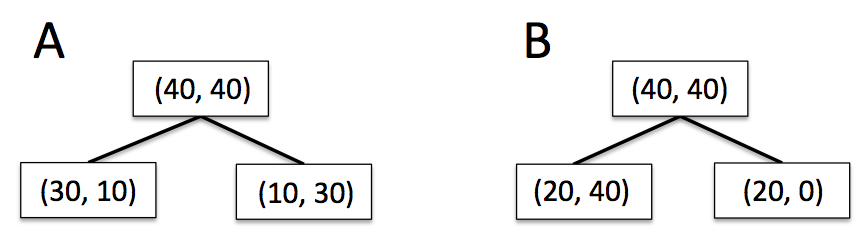

In [5]:
Image(filename='./images/03_22.png', width=600) 

$$
  I_E(D_p) = 1 - \frac12 = 0.5  \qquad  I_G(D_p) = 1 - (0.5^2 + 0.5^2) = 0.5
$$

A:
\begin{alignat}{2}
  & I_E(D_\text{left}) = 1- \frac14 = 0.25           & & I_G(D_\text{left}) = 1 - (\frac34^2 + \frac14^2) = 0.375\\
  & I_E(D_\text{right}) = 1 - \frac14 = 0.25         & & I_G(D_\text{right}) = 1 - (\frac14^2 + \frac34^2) = 0.375\\
  & IG_E = 0.5 - \frac48 0.25 - \frac48 0.25 = 0.25 \quad  & & IG_G = 0.5 - \frac48 0.375 - \frac48 0.375 = 0.125
\end{alignat}

B:
\begin{alignat}{2}
   & I_E(D_\text{left}) = 1- \frac46 = \frac13        & & I_G(D_\text{left}) = 1 - (\frac26^2 + \frac46^2) = \frac49\\\\
   & I_E(D_\text{right}) = 1 - 1 = 0                  & & I_G(D_\text{right}) = 1 - (1^2 + 0^2) = 0\\\\
   & IG_E = 0.5 - \frac68 \frac13 - 0 = 0.25 \quad    & & IG_G = 0.5 - \frac68 \frac49 - \frac28 0 = 0.167
\end{alignat}

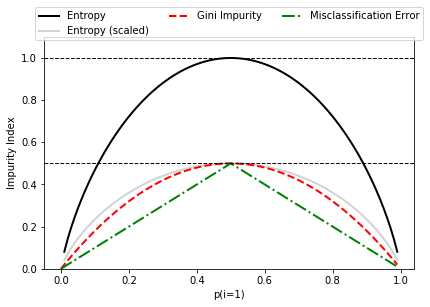

In [56]:
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.tight_layout()
#plt.savefig('./figures/impurity.png', dpi=300, bbox_inches='tight')
plt.show()

<br>
<br>

## Building a decision tree

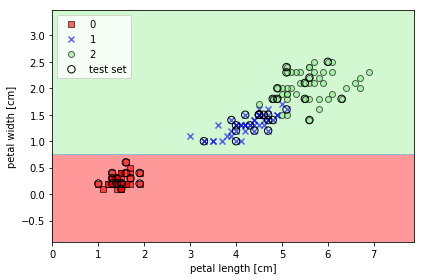

In [69]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1
                              , random_state=0)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/decision_tree_decision.png', dpi=300)
plt.show()

<br>
<br>

In [70]:
from sklearn.tree import export_graphviz

export_graphviz(tree, 
                out_file='tree.dot', 
                feature_names=['petal length', 'petal width'])

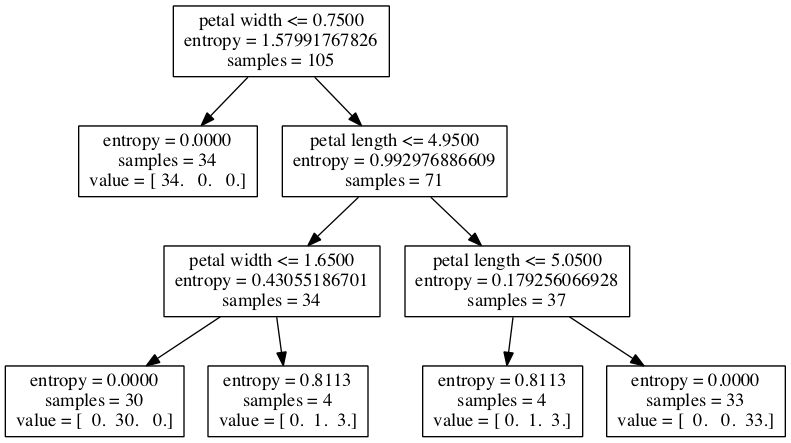

In [71]:
Image(filename='./images/03_18.png', width=600) 

We typically need to **prune** the tree to avoid overfitting

<br>
<br>

## Combining weak to strong learners via random forests

Combine **weak learners** to build a **strong** learner (Ensemble models)

Steps:
- Draw a random **bootstrap** sample of size n (choose n random samples out of total n samples with replacement)
- Make a **weak** decision tree from the bootstrap sample. At each node:
   - Choose $d$ features at random without replacement (defalut: $d = \sqrt{m}$)
   - Split the node using the best feature amongst the $d$ features, e.g. to maximize the information gain
- Repleat above steps for $k$ times (building $k$ trees)
- Aggregate the prediction by each tree by **majority voting**

Pros:
 - Don't need to prune the random forest in general, since the ensemble model is quite robust to the noise from individual decision trees
 - The larger the number of trees $k$, the better the performance of the random forest
 
Cons:
 - Large computational cost for large $k$
 

Hyperparameters:
 - $k$: the number of trees
 - $d$: the number of features that is randomly chosen for each split

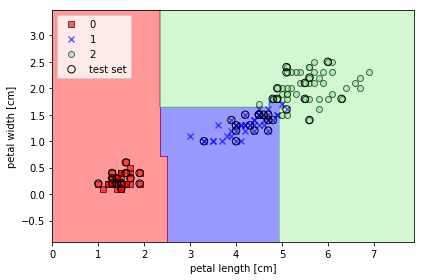

In [72]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10, 
                                max_features=2, #auto, sqrt, log2, None
                                max_depth=None,
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/random_forest.png', dpi=300)
plt.show()

<br>
<br>

# K-nearest neighbors (kNN)

A **lazy** learner:
- KNN doesn't learn a discriminative function the training data

KNN is an example of the **instance-based learning**
- learning is performed by memorizing the training dataset

KNN
- Choose the number $k$ of neighbors
- Choose the distance metric
- Find the $k$ nearest neighbors of the sample we want to classify
- Assign the class label by majority voting

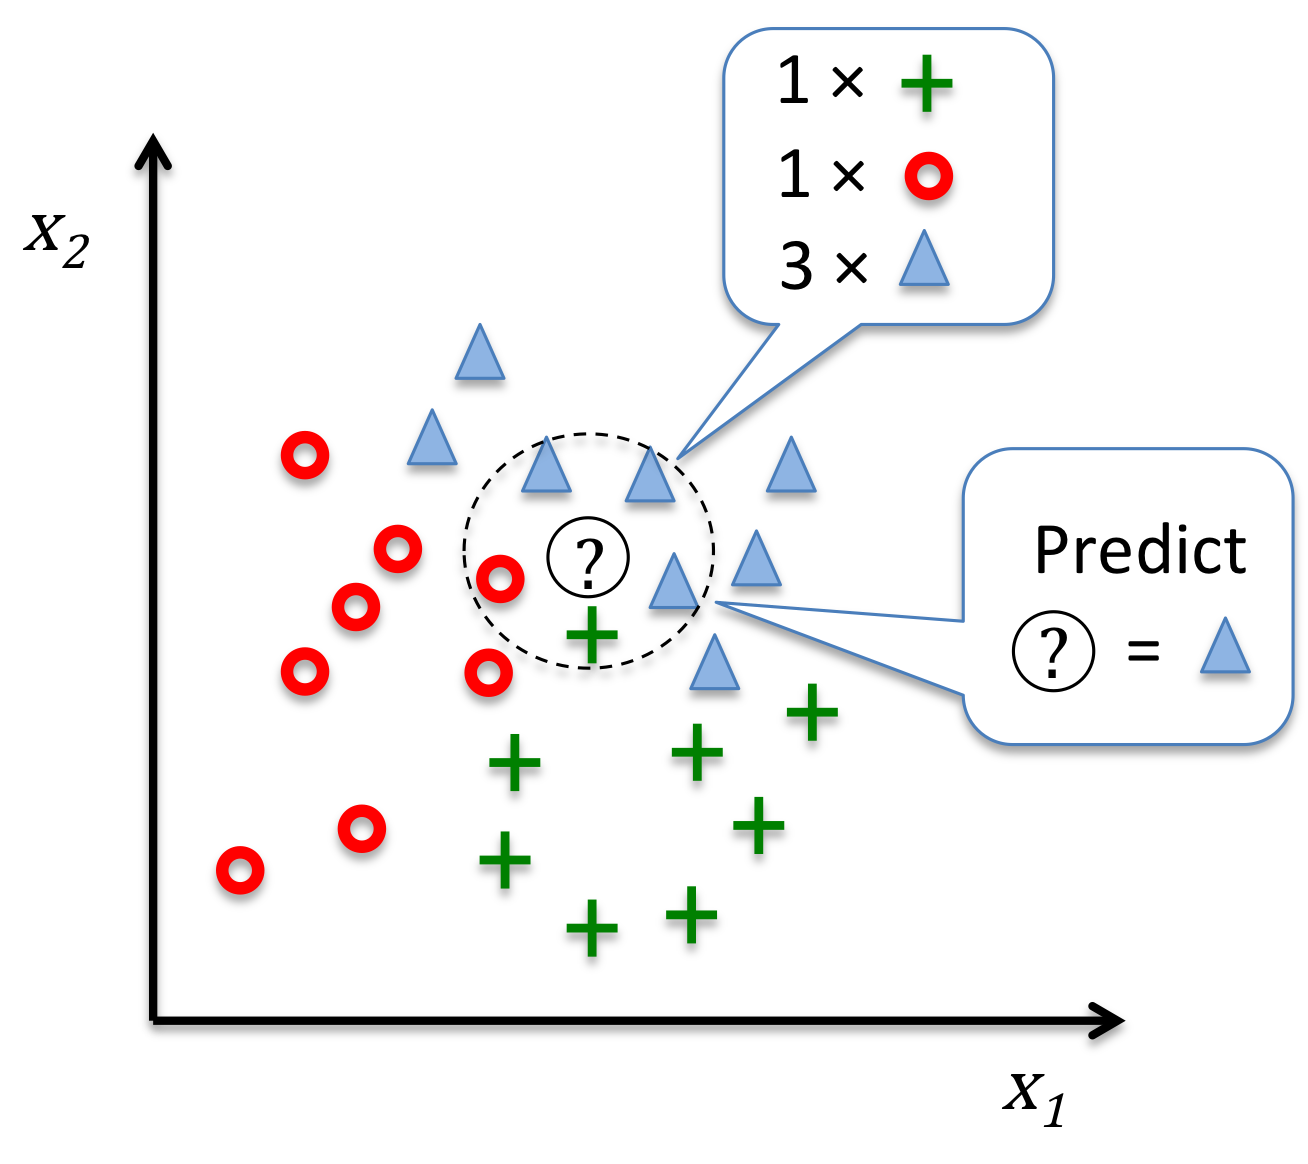

In [30]:
Image(filename='./images/03_20.png', width=400) 

Pros:
- The classifier immediately adapts as we collect new training data

Cons:
- Computational complexity grows linearly with the number of samples in the training data in the worst-case
- Susceptible for overfitting, especially when the input dimension is high (** curse of dimensionality** : for a fixed-size training set, the feature space becomes increasingly sparse as the dimension increases.)

Metrics

- Minkowski distance ($\ell_p$-norm)
$$
  d(x^{(i)}, x^{(j)}) = \left( \sum_k \left|x^{(i)}_k - x^{(j)}_k \right|^p \right)^{1/p}
$$
  - $p=2$ : Euclidean distance
  - $p=1$ : Manhattan distance ($\ell_1$-norm)

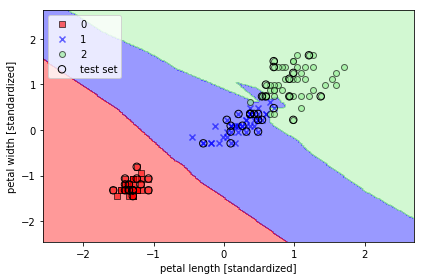

In [53]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/k_nearest_neighbors.png', dpi=300)
plt.show()

The right choice of $k$ is critical, to find a good balance between over- and underfitting

<br>
<br>